In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, LayerNormalization, Dropout, Layer
from skimage import io
import matplotlib.pyplot as plt
import warnings
import re
import math

2025-06-08 15:59:40.369151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749398380.598549      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749398380.670648      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Overview

The purpose of this project is for me to figure out how a Transformer works. I love data science, machine learning and artificial intelligence and would some day love to create my own AI as the resources required to do so become more accessible. I am not going to be reinventing the wheel here; much of this project is going to be code that has been written plenty of times before. The most important part of this project will be my explainations. I want to learn the components of a transformer well enough to teach it. If I can do that then I am able to apply that knowledge for when I eventually create my own AI.

Trigger warning: I do make jokes and use profanity occasionally where appropriate. This is my project. We are all adults and should be able to engage appropriately with all language especially outside of an academic setting. Also, I don't believe you are a true programmer if you don't quitely whisper explatives after spending hours of your life trying to debug code that just. won't. work. 

In [2]:
raw_data = pd.read_csv("/kaggle/input/language-translation-englishfrench/eng_-french.csv")
raw_data = raw_data.rename(columns={'English words/sentences':'english', 'French words/sentences':'french'})
raw_sample = raw_data.sample(5, random_state=420)
raw_sample

,english,french
96036,I can no longer remain silent.,Je ne peux plus garder le silence.
116648,Stop talking and start listening.,Arrête de parler et écoute maintenant.
56825,The CIA is watching you.,La CIA vous surveille.
21655,We're not married.,Nous ne sommes pas mariés.
49769,She is habitually late.,Elle est habituellement en retard.


For this project, we are going to use a kaggle dataset to generate an AI model that can translate an English sentence into French. The dataset we will be using is one that I found off of kaggle with rows containing sample English sentences in one column with the French translation in the other. I have literally no idea how to speak French, but it would sure be funny if I used a more refined version of this model to help me speak French on my tour through Europe. Maybe some day...

I will split this process into functions for modularity and readability purposes. I can better explain each component of the transformer architecture if I define the steps explicitly and expand on them in the markdown underneath. So this might not be the "proper" way to build an AI model, but it should be a really good way for me for me to explain what is happening. 

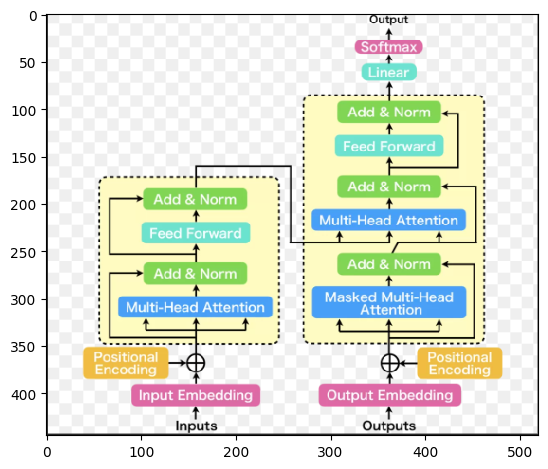

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
transformer_architecture = io.imread("/kaggle/input/images-transformer/transformer_architecture.png")
#io.title("Transformer Architecture Visual Diagram")
io.imshow(transformer_architecture)

To start, lets list out the steps we will be taking to build the components of our model:
<ol>
    <li><strong>Preprocessing</strong>: an initial cleaning of the English and French corpuses</li>
    <li><strong>Embedding</strong>: a projection of English and French words to a high dimensional space</li>
    <li><strong>Positional Encoding</strong>: added to embeddings to include information about the positions of words in a sentence</li>
    <li><strong>Multi-Head Attention</strong>: the mechanism that allows our model to learn from both English and French subspaces</li>
    <li><strong>Residual Connections</strong>: the "glue" between layers in the encoder and decoder components</li>
    <li><strong>Feed Forward Layer</strong>: a neural network</li>
    <li><strong>Encoder</strong>: learns the English subspace</li>
    <li><strong>Decoder</strong>: learns the French subspace</li>
    <li><strong>Transformer</strong>: combines the encoder and decoder to generate French predictions</li>
    <li><strong>Cross Entropy Loss</strong>: the loss function which calculates how far away the transformer prediction was from the expected output</li>
    <li><strong>Scheduler</strong>: dynamically adjusts learning rate with each training iteration</li>
    <li><strong>Optimizer</strong>: inflences how the model should make updates to its weights</li>
</ol>

The diagram above gives a very good visual of the architecture of a transformer-based AI. I would encourage those who want to learn the architecture to reference it frequently. 

In [4]:
VOCAB_SIZE = 50 # the total amount of unique words contained within our training data 
SEQ_LEN_MAX = 15 # the maximum number of words allowed for an input sentence/sequence 
EMBEDDING_DIM = 8 # the length of the vector used to represent any english or french word
LAYER_NUM = 2 # the amount of encoder and decoder layers in our model
HEAD_NUM = 2 # the number of attention heads that our model will use to learn 
FEEDFORWARD_DIM = 16 # the number of nodes contained in the hidden layer of our feed forward neural network component
DROPOUT_RATE = 0.1 # the percentage of nodes that are decativated during each training iteration
EPOCHS = 5 # the number of full passes through our dataset the model will take during training
BATCH_SIZE = 5 # the number of subsets we slice our dataset into for iterative updates to model weights

Before diving into the model, I want to define some of the training parameters that we will need in order to create our transformer. Ideally, hyperparameters like the number of attention heads, dropout rate and activation functions would be tuned through multiple iterations of model validations. However, configuring the best inputs takes a lot of time and compute cost so instead I will make some educated guesses for what they should be. I'll probably configure them randomly to start with and mix them up when I actually decide to light up the whole model. 

# Preprocessing

In [5]:
def preproc(string):
    string = string.lower()
    string = re.sub(r"[^\w\s]", "", string)
    return string

Before we feed the English and French sentences into our model, it's a wise decision to clean and preprocess the data. As humans, we know that "Carrot", "carrot" and "(carrot) " are all strings that contain information about a skinny, orange vegetable. Semantically, we tend to assume that we can treat these words as being identical, so lets allow our model to do the same. 

Using this preproc function, we can allow our model to treat all of these words identically. However, this does not mean that we must follow this process to a T. This algorithm can be customized in different ways; we can even chose to train our model treat the words "carrot" and "CARROT" differently if we really want to. However, I chose the lower and strip option for simplicy's sake. 

In [6]:
def add_sos(string):
    return '<sos> ' + string

def add_eos(string):
    return string + ' <eos>'    

SOS and EOS stand for "start of sequence" and "end of sequence", respectively. These SOS and EOS tokens are special "words" that we will add to our data in order to signify to our model that we are either starting or ending a sentence. People gain the exact same sentiment through punctuation and first letter capitalization. In the instance that our input contains multiple sentences, we can also teach our models to comprehend that information. But for this type of problem where we are given a single sentence, we can just hard code them in. 

In [7]:
raw_sample['english'] = raw_sample['english'].apply(preproc)
raw_sample['french'] = raw_sample['french'].apply(preproc)
raw_sample['french'] = raw_sample['french'].apply(add_sos)
raw_sample['french'] = raw_sample['french'].apply(add_eos)
raw_sample['english'] = raw_sample['english'].apply(add_eos)

raw_sample

,english,french
96036,i can no longer remain silent <eos>,<sos> je ne peux plus garder le silence <eos>
116648,stop talking and start listening <eos>,<sos> arrête de parler et écoute maintenant <eos>
56825,the cia is watching you <eos>,<sos> la cia vous surveille <eos>
21655,were not married <eos>,<sos> nous ne sommes pas mariés <eos>
49769,she is habitually late <eos>,<sos> elle est habituellement en retard <eos>


It is most important to add sos and EOS tokens to the French sequence, especially SOS. This has to do with the way the target language is processed by the decoder. In order for the decoder to kick off, we need a token that identifies the start of a sentence (I will explore this further in the decoder definition). The encoder language, however, does not require an sos token. In some cases it can make sense to add the EOS token to the input language to help the AI identify when to stop predicting outputs so I thought I would give it a shot with this project. I may change this later if it affects training negatively

In [8]:
def build_vectorizers(eng_texts, fr_texts, vocab_size, max_length):
    eng_dict = TextVectorization(max_tokens=vocab_size, # the maxmimun number of words our model can know
                                 output_mode='int', # IDs for all unique words (we will change these to embeddings)
                                 standardize=None, # we already did this in the preproc function
                                 output_sequence_length=max_length) # the maximum number of words our sentences can have
    fr_dict = TextVectorization(max_tokens=vocab_size,
                                output_mode='int',
                                standardize=None,
                                output_sequence_length=max_length+1)
    eng_dict.adapt(tf.constant(eng_texts))
    fr_dict.adapt(tf.constant(fr_texts))
    return eng_dict, fr_dict

def vectorize_and_prepare(texts, vectorizer):
    token = vectorizer(tf.constant(texts))
    token = tf.cast(token, tf.int32) 
    return token


TextVectorization is a function within the tensorflow library that allows us to do a few things that are important for creating our model:
<ol>
    <li><strong>Standardize Text</strong>: clean our Natural Language data </li>
    <li><strong>Tokenize Text</strong>: divide sentence inputs to word tokens</li>
    <li><strong>Build our Vocabulary</strong>: the collection of unique words that our model can understand</li>
    <li><strong>Add Padding or Truncate Text</strong>: allows for all sequences to be the same length so the math works and our model doesn't have a stroke</li>
    <li><strong>Map Tokens to Integers</strong>: this will be important for keeping words unique so they can be mapped to embeddings</li>
</ol>

There are plenty of ways to accomplish these points. For instance, we can use pretrained BERT encoders to handle the text vectorization <em>and</em> embedding process that would probably work better for solving this problem. But this way is straightforward enough and we already have it preloaded into tensorflow so I'll just go along with this one. Also, the reason why I am standardizing the input before plugging the data into this function is so that the tokenizer doesn't strip the EOS and SOS unique indicators. SOS can mean 'start of sequence' but it can also mean 'save our skins', so I am just making sure the model can draw distinctions. Might not really be needed but I'd rather take care of edge cases if I can think of them.

In [9]:
eng_dict, fr_dict = build_vectorizers(raw_sample["english"], raw_sample["french"], VOCAB_SIZE, SEQ_LEN_MAX)
eng_tensor = vectorize_and_prepare(raw_sample['english'], eng_dict)
fr_tensor = vectorize_and_prepare(raw_sample['french'], fr_dict)

print(eng_tensor)
print("\n")
print(fr_tensor)

tf.Tensor(
[[20 23 15 17 13 11  2  0  0  0  0  0  0  0  0]
 [ 9  8 24 10 18  2  0  0  0  0  0  0  0  0  0]
 [ 7 22  3  6  4  2  0  0  0  0  0  0  0  0  0]
 [ 5 14 16  2  0  0  0  0  0  0  0  0  0  0  0]
 [12  3 21 19  2  0  0  0  0  0  0  0  0  0  0]], shape=(5, 15), dtype=int32)


tf.Tensor(
[[ 2 20  4 12 11 22 18  9  3  0  0  0  0  0  0  0]
 [ 2 29 27 14 23  5 17  3  0  0  0  0  0  0  0  0]
 [ 2 19 28  6  7  3  0  0  0  0  0  0  0  0  0  0]
 [ 2 15  4  8 13 16  3  0  0  0  0  0  0  0  0  0]
 [ 2 26 24 21 25 10  3  0  0  0  0  0  0  0  0  0]], shape=(5, 16), dtype=int32)


2025-06-08 15:59:55.433259: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Embedding and Positional Encoding

<stong>Token embedding</strong> can be a confusing concept so lets talk about it. Machine learning models are only able to find patterns using numbers; they can't understand raw text on their own. So an early tool that data scientists employed was <strong>One-Hot Encoding</strong>. This was a sparse representation where each row would be a sentence and each column representing a word in the vocabulary. If the word for a column was contained within the row input, a 1 would be assigned to that cell. If the word isn't in the sentence, a 0 would be assigned. This spawned plenty of approaches that are still used today to solve NLP problems like TF-IDF (Term Frequency - Inverse Document Frequency) and the BoW (Bag-of-Words) approach.

But sparse representations have some problems:
<ol>
    <li>They get VERY large VERY quickly as our vocabulary grows</li>
    <li>Most are not the best option at capturing the relationship between tokens ("King" is related to "Queen" as much as it is related to "Bacterium" for some sparse representations)</li>
    <li>They cannot capture <strong>polysemy</strong> or words having more than one meaning like light in "a light touch" versus "ultraviolet light"</li>
</ol>

So what is the first step we need in order to give our model enough ammo to learn these complexities of natural language? To start, we need embeddings.

<strong>Embeddings</strong> are a fixed-number vector of numbers (float, integers, etc.), the size of which is chosen by the AI developer, that are used to represent very complex data, in this case the words in a sentence. If we wanted to represent the word "pot" in three dimensions, we could do so using a vector like \[-1.39, 0.2, 4.47]. And if we want too, a human could plot this vector on a 3D coordinate plane along with the coordinates of other words and we could visually process the relationship between words, how close or far away they are from one another. 

In reality, the dimensions of these embeddings are much much larger than this while still being a lot smaller and more compact than sparse matrices. We could have tens of thousands of dimensions if we really wanted to. Where this gets tricky is that humans cannot see this relationship between the words projected into higher order dimensions. However, we <em>are</em> able to teach AI models how to see these relationships because, as it turns out, the math still works through dimensions past 3D. And now for the real questions: <strong>How do we know what numbers to pick for these vectors? How can we ensure that similar words are projected similarly to higher dimensional spaces?</strong>

There are many different algorithms that we could use to embed the words in our corpuses. For instance word2vec, GloVe and BERT are all pretrained and can vary in their level of learning power. However, for this project we are going to keep it simple by using the embedding function in tensorflow. All this really is to start is a lookup table; each word is given a unique index so for "pot", the index might be 21 or some number. The key here is that the number will correspond to a randomly initialized vector of weights of any dimension that we so choose which is then updated interatively during model training. 

So each word is just given a dense layer of whatever size we want for the model to learn which means we are just adding it as a layer to a neural network. Ideally, I would probably use BERT in the future for these embeddings only because the way it was trained contains contextual information off the rip. Our current embedding method does not and that contextual info must then be fully learned by our model during training. 

Our embedding technique effectively captures the meanings of individual words in isolation, but it lacks information about their position in a sentence. To address this, we incorporate positional encoding, which is crucial for NLP models—especially Transformers. Without positional encoding, the model has no sense of word order, which is essential for understanding phrases like peanut butter and jelly versus jelly and peanut butter. While contextual embeddings help disambiguate homonyms like “tear” in tear drop vs. tear and rip, positional information enables the model to assign meaning based on where each word appears in the sequence—improving both syntactic and semantic understanding. This positional context is essential for capturing syntax, predicting the next word in a sequence, and correctly inferring parts of speech.

For example, consider the following sentences:
<ul><li>She is reading the book.</li><li>She does not enjoy reading.</li></ul>

In the first, the word "reading" acts as a description for an action applied to the book. In the second, the word "reading" acts as a gerund (noun) identifying the <em>act</em> of reading. Positional encoding is a preprocessing tool that can help greatly enable our model to discern these sequential relationships. Granted, we still need to implement multiheaded attention which will also help, but this is the first step at fascilitating AI learning. 

The positional encoding class defined below turns the embedding indices matrix above into tensors containing full embedding information and <em>then</em> applying the positional encoding. I found this code in another Kaggle project because I ended up having some issues with the way that ChatGPT was advising me to implement it as a function. It might be a better option to keep it as a function rather than making an entire class but if it works, I'll use it I guess. 

In [10]:
class EmbeddingAndPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.keras.ops.not_equal(inputs, 0)

Much similarly to embedding techniques, there are MANY different methods for positional encoding; however, we will be using one of the more basic forms for simplicity reasons: <strong>sine-cosine encoding</strong>. The function is defined as...


\begin{align*}
\text{PE}(pos, i, d) =
\begin{cases}
  \sin(\frac{pos}{10000^{\frac{2i}{d}}}), & \text{if } i\%2=0 \\
  \cos(\frac{pos}{10000^{\frac{2i}{d}}}), & \text{if } i\%2=1
\end{cases}
\end{align*}

Where...
<ul><li>pos = the position of a token embedding occurance in a sequence</li><li>i = the index of the current value in the token embedding</li><li>d = the dimensionality assigned to each embedding vector</li></ul>

The formula can be a little difficult to follow but essentially, we can use periodic functions (in this case sine and cosine) to generate unique encodings for words <strong> occuring in the same sequence</strong>. For even number indices, we use sine and for odd numbers we use cosine. This combination of alternating periodic functions allows us to smoothly capture the differences in positions, while the internal scaling calculations help the values to grow slowly for lower dimensional values and quickly for higher dimensional ones. So you will notice, we aren't actually using the information contained <em>in the embedding</em> for this operation. This logic is purely positional, it doesn't need to be derived from the embedding itself. 

In the end, this encoding is added element wise to each embedding in the sequence. Keep in mind that this encoding will be the uniform across all sequences for the model you define. 

# Multi-headed Self Attention

Self-Attention is pretty much the bread and butter of how a Transformer works. I am not going to lie to you, what self attention is doing and how it works is kind of absurd even in the realm of Artificial Intelligence. So I will go through and explain in detail each step of the process to the best of my ability.

Okay so before diving into self attention, let me explain a little bit about a couple of the popular NLP methods available up to this point. RNN models are pretty good at dealing with sequential data (text, in this instance) for certain problem sets. In another project, I've used the learned hidden state of RNNs on news headlines to aid in the classification of fake or real news articles. However, one of the major drawbacks of using this model architecture is that the hidden state of each is slightly recalibrated when processing each new token in a sequence. So what ends up happen is that context learned from the beginning of the corpus is likely to be overwritten in the hidden state as we feed the model more and more information. LSTM models seek to rectify this issue by creating separate channels for long ("older") and short ("newer") memories. But for very large texts, even this is not a complex enough architecture to help our model recall long term context. 

As a second point, not only are we looking for our model to <em>recall</em> long term context, we also need our model capture the relationship <em>between</em> long term context, short term context and every permutation along the gradient of those components. So in order to try and help our model become less baised for later token occurences AND capture contextual relationships among words, we repeatedly implement a process known as <strong>Attention</strong> (see the figures below).

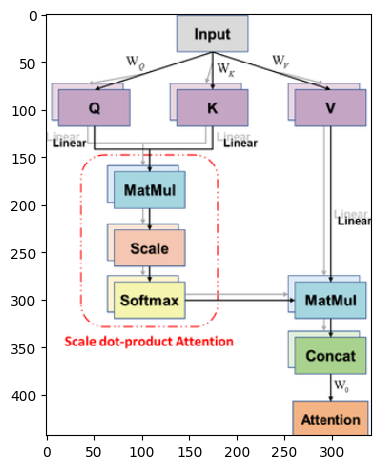

In [11]:
attention = io.imread("/kaggle/input/images-transformer/self_attention_architecture.png")
#io.title("Transformer Architecture Visual Diagram")
io.imshow(attention)

In [12]:
# Scaled dot-product attention function
def scaled_dot_product_attention(Q, K, V, mask=None):
    matmul_qk = tf.matmul(Q, K, transpose_b=True)
    d_k = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

    if mask is not None:
        scaled_attention_logits += (tf.cast(mask, tf.float32) * -1e9)

    #print(scaled_attention_logits.shape)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    #attention_weights = Dropout(DROPOUT_RATE)(attention_weights)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights

\begin{align*}
\text{SDPattention}(Q, K, V) =
  \text{softmax}(\frac{QK^T}{\sqrt{d_{k}}})
\end{align*}


When explaining really complex functions like multi-headed self attention, I like to take the approach of describing our inputs, outputs and overarching goal so that people don't lose track of what we are trying to do with this implementation. So lets begin with defining these 3 components of the transformation process before passing the sentence off to the decoder:
<ul><li><strong>Input</strong>: the <em>entire</em> embedded sentence.</li><li><strong>Output</strong>: an UPDATED embedding representation of the <em>entire</em> embedded sentence (mirrors the dimesionality of the input).</li><li><strong>Goal</strong>: for each embedding in the sequence, we update the numbers within the vector so that they contain contextual information about all words (including itself) in that sequence.</li></ul>

How do we do this? 

We start by introducing 3 sets of linear transformations for which we pass in our embeddings. These transformations contain a dense vector of learned wights, just like a neural network, only it's much more simple. These transformations are referred to as the Queries, Keys and Values for a word embedding. 

Now, for every combination of word pairs (B \[lets call this the base word\], R \[lets call this the reference word\]) in the input sentence, we perform a dot product of the B query to the R key producing a 1 x 1 dimensional scalar for each pair. All together, we will be left with a sequence length by sequence length matrix for the English inputs. Each cell in this matrix represents the degree of similarity that word R has with word B. The specific term for this is the <strong>raw attention score</strong> between those embeddings. When we have large values produced for this dot product, we say that those words <strong>attend</strong> to one another, which means...
<ol><li>The words have some sort of strong relationship that has been <em>learned</em> by the model via parameterized weights.</li>
<li>The relationship being captured could be semantic (the actual meaning of a word); it could be syntactical like having similar parts of speech; et cetera.</li><li>Or we could even just say that the model finds the appearance of one word aids in predicting the other.</li></ol>

Overall, what we are doing is giving the model ammo to learn something about the relationship of one word to another.

Next, we doing some scaling and normalization to the attention scores. This process can vary but it pretty much always ends with passing the matrix rows through the softmax function. Which ensures that the sum of all attention scores <strong> for each base word </strong> comes out to 1. These percentages produced by softmax for each base word attention score gives us an idea of how much a reference word attends to it relative to the entire group of reference words.

Something to keep in mind at this point is that each query and value embedding instance will result from the same base word. But it is the key embedding instance that will contain information about a given reference word. So the last final big mathy part is to apply the vector of attention scores from EVERY base word query to EVERY one of the corresponding value embeddings for that same base word. This will produce a matrix where the columns are the embedding dimensions for every word and the rows are vectors that result from applying the attention weights to the value vector of that word. When the rows of that matrix are summed together, we finally get the updated embedding vector for that word. 

So to keep clear track of each matrix size... kinda:
<ul>
<li>Queries, Keys, Values are (N x M) dimensions where N is the number of words in the sequence and M is the embedding size of each word</li><li>Attention Matrix (scaled dot product) is (N x N) for each pair of words in the sentence (permutation not combination, order matters)</li><li>Attention Output after applying the Attention Matrix to the Value Matrix is (N x M)</li>
</ul>

Now, all we do is repeat that exact process like 8 times or whatever they did in the paper, concatenate the results and transform that do get our newly updated sequence of embeddings.

Easy enough, right...?

(The reason I say "kinda" is becasue the way this model processes batches during training alters this a bit. But that is irrelavent to the core fundamental concept.)

In [13]:
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        attention_output, _ = scaled_dot_product_attention(Q, K, V, mask=mask)

        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.d_model))

        output = self.dense(attention_output)

        return output
 

Above this is the code for defining the multiheaded self attention layer. For the purposes of model efficiency and performance, we can batch process each attention head by dimensions. So each head literally is assigned 1/8th of all input tensors if we have 8 heads. Personally, I find this to be a bit strange and I wonder if there is a way to improve upon this batch process so that more can be learned about the interactions between different groupings of model dimensions. Like, instead of counting out the first 8 dimensions, randomly select the 8 dimensions dbefore training that will be processed by each head. Not sure if this would do anything, it might make things worse but at some point, I would like to try it when I begin building out my own AIs.

One thing that you may notice that is a little weird about this class is the call function. <strong>Why are we defining queries, keys and values input separately at the time of the function call when they all come from the same input tensor? Couldn't we just use the tensor itself during the call?</strong> This design decision will make sense when we move to the decoder definition. 

# Feed Forward Network

In [14]:
class FeedForwardNetwork(Layer):
    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

The feed forward class is probably the easiest part of the transformer architecture to understand. There is a lot of work that can be done adding and tuning dimensions of these dense neural network layers. So because this is a class, the structure we are defining in the function will be the same for the feed forward layers in both the encoder and the decoder. If we wanted a different hidden layer stucture for each, we would need to define it manually within the encoder and decoder. 

# Residual Connections, Layer Normalization, and the Dropout Method

In my (un)professional opinion, this is <strong> the most crucial component of LLM architecture </strong>. Honestly, it's a shame that residual connections don't get as much recognition as other parts of the model. This mechanism plays a key role in enabling AI to really grasp deeper patterns from the input. Think of residual connections as a stabilizer: the model performs complex computations within each substructure. However, the most effective training approaches in the world of AI/ML often involve making minute, incremental adjustments to the input. When we allow the model to take large leaps in learning, we risk encountering one of the biggest challenges in all of AI/ML.

<strong>The Vanishing/Exploding Gradient Problem</strong> arises when repeated multiplication during backpropagation causes gradients to either shrink exponentially (vanish) or grow exponentially (explode). Since we allocate space for many different weights to shape the model’s learning, some gradients may become useless, either increasing uncontrollably or decreasing towards negative infinity. Residual connections help mitigate this by allowing the model to retain more information from the original input after applying complex transformations. While the core idea is simple (add the learned vector back to the original input) the impact on learning stability can literally make or break a model’s performance.

Make no mistake, an LLM can function without residual connections. But their impact on stability and learning efficiency is far from negligible. Sometimes, the simplest mechanisms provide the most significant benefits, and residual connections exemplify this principle perfectly.

In [15]:
def residual_stream(input_tensor, architecture_output, layer_norm, dropout):
    architecture_output = dropout(architecture_output)
    residual_connection = input_tensor + architecture_output
    normalized_connection = layer_norm(residual_connection)

    return normalized_connection

Instead of adding the residual stream inside the multihead class definition, I chose to add it as a function outside the encoder definition for a couple of reasons. One, I felt it kept the intuiton of the code consistent to how a human would process the transformer model architecture. Two, if I wanted to go back and play around with the residual connection, I could do so without accidentally fucking up the entire attention mechanism. So do as you please; there are a lot of cool design decisions you can make when implementing a transformer even beyond directly modifying the model learning process. And finally, here is a link if you would like to know a little more about residual connections: [Residual Connections Article](https://tensorrt-llm.continuumlabs.ai/transformer-architecture/residual-connections)

# Encoder Definition

In [16]:
class EncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.supports_masking = True
        self.multihead_attention = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = FeedForwardNetwork(embed_dim, ff_dim, dropout_rate)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, input_tensor, mask=None):
        attn_output = self.multihead_attention(input_tensor, input_tensor, input_tensor, mask=mask)
        residual_connection_msa = residual_stream(input_tensor, attn_output, self.layernorm1, self.dropout1)
        
        ffn_output = self.ffn(residual_connection_msa)
        residual_connection_nn = residual_stream(residual_connection_msa, ffn_output, self.layernorm2, self.dropout2)
        
        return residual_connection_nn

class Encoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.supports_masking = True
        self.encoder_layers = [EncoderLayer(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)]

    def call(self, x, mask=None):
        for layer in self.encoder_layers:
            x = layer(x, mask=mask)
        return x

So for the encoder definiton, we are putting everything we've built up to this point together into the layer definition and then rerunning that process over and over again. So one input is processed multiple times by the encoder. As a small note, one tactic that makes this process more efficient is that use of batch processing. So the encoder is able to parallel process multiple sequences at a time which is why the input tensor is tridimensional instead of just a matrix. 

Referring back to the broader project goal, this encoder is how we are teaching the model to learn from the language we want to translate. In this case, each sequence input will be English. The decoder is where we teach the model to learn the French translation. 

# Decoder Definition

One thing that really bugged me when I was trying to think about how an LLM might work is the encoder versus the decoder. It didn't make intuitive sense to me why we even need two distinct structures to help us translate a sentence. So I will explain it to you straight up in a way that I think makes the most sense. Hopefully you get out of it what took me WAAAAAAAAY too long to learn. 

In the context of this project, ask yourself this: <strong>What inputs are we using to generate the french sentence</strong>? Well that's easy, our inputs would just be the sequences and word embeddings of the input, aka. the english sentence... right? Wrong. In this context, could you MAYBE find a way to just use the english sentence and one shot a french translation prediction, sure. But for a large scale chatbot to generate entire novels from a detailed user input? There's absolutely no chance. So how is it done?

Natural Language Processing tasks can be categorized under a specific type of statistical modelling system called <strong>Autoregression</strong>. For a problem set to be autoregressive, all this means is that the prediction we make is dependent upon the result of previous predictions. More pointedly, the problem is recursive (not to be confused with the programatic definition of recursion). For instance, if we were tasked to complete the sentence "I love peanunt butter and", most of us would assume the word that could best complete the sentence would be "jelly." Not simply because we have historical context for peanut butter and jelly being two common ingredients for a popular sandwich, but really it's because we are using the previous tokens themselves to inflence our prediction: "peanut", "butter", "and". 

So when we think about a transformer not as a sentence predictor but as a <em>token</em> predictor, we come to realize that we can also use every other token previously predicted by the model to aid in predicting the next word ALONG WITH the english sentences that we are parsing. This is exactly what is happening in the decoder. The input to the decoder is all of the words in the french sentence that came before the token that we are predicting in our current iteration. This took me an embarrasingly long time to realize and it's why we have both an encoder and a decoder. The encoder holds information to process our input english sentence; the decoder allows us to use previously predicted french tokens as autogressive features to build out the rest of the translation.

In [17]:
class DecoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.masked_mha = MultiHeadAttention(embed_dim, num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = FeedForwardNetwork(embed_dim, ff_dim, dropout_rate)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        attn1 = self.masked_mha(x, x, x, look_ahead_mask)
        residual_connection_mmhsa = residual_stream(x, attn1, self.layernorm1, self.dropout1)

        attn2 = self.cross_attention(residual_connection_mmhsa, enc_output, enc_output, padding_mask)
        residual_connection_mhca = residual_stream(residual_connection_mmhsa, attn2, self.layernorm2, self.dropout2)


        ffn_output = self.ffn(residual_connection_mhca)
        residual_connection_ffnn = residual_stream(residual_connection_mhca, ffn_output, self.layernorm3, self.dropout3)

        return residual_connection_ffnn

class Decoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.decoder_layers = [DecoderLayer(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, look_ahead_mask=None, padding_mask=None):
        for layer in self.decoder_layers:
            x = layer(x, enc_output, look_ahead_mask, padding_mask)
        return x

The decoder definition is honestly pretty structurally similar to the encoder. There are self attention mechanisms, feed forward layers, residual connections all playing a role in helping the model to learn to translate a given English sentence into French. But there are some key differences in the way that some of these components work that I will go into next.

# Masked Multiheaded Self Attention

This part of the decoder is pretty straightforward if you understand that predictions occur per token and not per sentence. To keep the model from "cheating" we apply a matrix mask to zero out only the token we are currently predicting and any subsequent tokens in the sequence. 

So say we have the input "The cat sat on the mat" which translates to the french sentence "Le chat s’est assis sur le tapis". If we were at the point in our training process where we are predicting the token "assis", we can use the tokens "Le", "chat", "s'est" to help generate a prediction. But "assis", "sur", "le", and "tapis" is not representative of an input that we could possibly know during model inference. So for training, when we have the token "assis" we need to apply a mask before running through multiheaded self attention that is kinda like this: `["Le", "chat", "s’est", "assis", "sur", "le", "tapis"] x [1, 1, 1, 0, 0, 0, 0]`. 

Now of course the tokens will be token embeddings so they aren't words but you get the idea. After this we just apply a very very small number to the zero entries like -1e9 because 0 is a value within a meaningful range for embedding values. So in a way, we are kinda using the vanishing gradient problem to help us because we need a way to create nonmeaningful tokens. Kinda cool how we can use a problem to solve another. 

# Multiheaded Cross Attention

Now this is where things get REALLY interesting. So if you remember in the class definition for mutliheaded attention I posed this question: <strong>Why are we defining queries, keys and values input separately at the time of the function call when they all come from the same input tensor? Couldn't we just use the tensor itself during the call</strong>? Well here is your answer: <strong>Multiheaded Cross Attention</strong>. 

The way that Multiheaded Cross Attention and Multiheaded Self Attention both function is one-for-one mathematically. Everything from the Queries, Keys and Values to the attention matrix all works the exact same. The key distinction is the input. In order to pass English information to our French decoder, we use the encoder output to create our keys and values. However, the queries come from the masked-multiheaded self attention output of the previous decoder substructure. 

So what we are literally doing is answering this question: <strong>For a French input sequence, how do those French embeddings attend to all the other English embeddings present in its corresponding English translation sequence</strong>? You may notice that this means the computed attention matrix may not have square dimensionality from the queries and keyes matrix multiplication, but don't worry because it all works out in the end. I won't go through the math explicitly again but if you follow back the operations, you can easily see that the resulting tensor will have dimensions mirroring the decoder's input tensor to the cross attention function. 

# Transformer Defintion

In [18]:
# Define Transformer model that connects the encoder and decoder
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout_rate)
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, encoder_input, decoder_input, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(encoder_input, mask=enc_padding_mask)  # (batch_size, input_seq_len, d_model)
        dec_output = self.decoder(decoder_input, enc_output, look_ahead_mask, dec_padding_mask)
        pre_softmax_outputs = self.final_layer(dec_output) # formerly logits. 
        return pre_softmax_outputs

For the transformer definition, we are taking the encoder and decoder classes, running them and combining their outputs to retrieve a prediction for our next token. The final layer projects the decoder output to logits... but there is a problem. Something I began asking myself (because I am a frickin nerd) is <strong>how exactly the dense layer knew how to turn hidden layer values into logits?</strong> Until I realized... it doesn't. 

In the mathematical sense, logit refers to a specific function with a defined formula (shown below) which maps probabilites (where the set of all possible values is \[0, 1]) to all real numbers, R (-inf, inf). But the algorithm that that we are trying to implement is actually going in the opposite direction. We are looking to take real number outputs for possible words and constrain them to probabilities between 0 and 1. 

\begin{align*}
\text{logit}(p) = \log\left( \frac{p}{1 - p} \right)
\end{align*}

So... these inputs aren't actually logits at all. Now I am not a true mathematician at heart, my "style" of programming and problem-solveing tends to be very fast-and-loose; I am a cowboy, not a sheriff. However, this is not one of those times. The raw dense outputs that an AI model prodces for softmax to consume ARE NOT LOGITS!!! My ass was sitting here, staring at my screen for a hot minute trying to figure out how logits are produced from a dense layer only to realize that the ML engineer who came up with this name probably also failed out of highschool math. 

So I will set the record straight from here on out and refer to these as "pre-softmax outputs" and start a fist fight with anyone who tries to suggest otherwise. 

# Masking Functions

In [19]:
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)  # (batch_size, seq_len)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp,tar):
    enc_padding=create_padding_mask(inp)
    look=create_look_ahead_mask(tf.shape(tar)[1])
    dec_pad=create_padding_mask(inp)
    tar_pad=create_padding_mask(tar)
    look_mask=tf.maximum(tar_pad,look)
    return enc_padding, look_mask, dec_pad

We've discussed masking already so I won't go into it too deep. The padding mask is used when our input sentences for english or french don't fit to the maximum allotted sequence length for our tensors. We add this mask to tell the model "when our EOS token is reached, don't bother processing any more information". None of the remaining placehorlder tokens are useful to you but we need the space in order to get the matrix math to work. Look ahead masks are used when we don't want our encoder to "cheat" by looking at tokens it couldn't possibly know at model inference during training. 

As an aside, I wanted to mention that implementing these masks was SIGNIFICANTLY more difficult than people realize. Understanding and keeping track of tensor dimensions messed me up a lot... but not as badly as it confused ChatGPT. I will go into this at the end of the project but ChatGPT (and this was just my experience with it trying to solve this problem) had a very difficult time keeping track of tensor dimensions. It was a fantastic asset when it came to creating the skeleton to get me like 80% of the code done, but good GOD it could not figure out that final 20% very well. I anticipate AI algorithms will only continue to code better with time but right now, I know for a fact it can't take the place of a senior dev. 

# Cross Entropy Loss

In [20]:
def loss_function(real,pred):
    loss=loss_object(real,pred)
    mask=tf.cast(tf.not_equal(real,0),loss.dtype)
    loss*=mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

I was pretty back-and-forth on how in-depth I wanted to go explaining cross-entropy loss only because it is so applicable to many many different AI/ML domains. But I think that explaining it now will help me out with my understandings in the long run. When you read most academic papers and textbooks, they will do a very good job at breaking down the math and how it works. Where we fail is understanding in plain writing what we are actually trying to accomplish with these algorithms. So I will explain this much like I have explained each component so far to try and get around this barrier. 



For any ML/Deep Learning problem, loss is defined as this:

\begin{align*}
L(\hat y, y) = \text{how much the AI prediction (} \hat y \text{) differs from the expected output (} y \text{)}
\end{align*}

In our case, y hat and y are the predicted next word by the model and the expected next word from our training data, respectively. You likely already know this but it is the machanism that allows us to recalibrate our model weights using gradient descent. After multiple training runs, our model's predictions for the next word becomes better and better because we teach it incorrect from correct preditions using loss and update our weights to achieve as close to our correct output as possible.

<strong>Cross Entropy Loss </strong> is a specific type of loss function designed for measuring the difference between actual and predicted probability distributions for classification tasks. It is defined like this:

\begin{align*}
L(\hat y, y) =  - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
\end{align*}

Where...
<ul>
    <li>C = the number of classes (in this case, every word in our vocabulary is a class)</li>
    <li>yi = the true class (word)</li>
    <li>yi hat = the predicted class (word)</li>
</ul>

In the cross entropy loss function from tensorflow, the pre-softmax output (logits) are turned into a distribution of probabilities across our vocabulary using (you guessed it) the softmax function.

\begin{align*}
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
\end{align*}

In the instance of binary classification problems, cross entropy loss looks like this:

\begin{align*}
L(\hat y, y) =  - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right)
\end{align*}

Lets say that our corpus is only two words: "cat" and "dog". The value for our true word vector in going to either be \[0, 1] for dog or \[1, 0] for cat. This is a sparse representation where the only hot encoding corresponds to the true word from our corpus. Lets say the word we are trying to predict is "cat".

Our model is going to generate a prediction for the next token that might look something like this: \[0.6, 0.4]. Here, the AI is leaning towards the token "cat" but it's close to a 50/50 guess between the words available. Plugging the values into our above formula, we get this:

\begin{align*}
L(\hat y, y) =  - ( 1 \times \log(0.6) + 0 \times \log(0.4)) \\
=  - (\log(0.6)) \\
=  0.5108256237659907
\end{align*}

The term for "dog" is completely zeroed out and the only part of our calculation that really matters is the value that the model gave for the word "cat". 

The plot below represents how the rest of the function behaves given different inputs for the predicted probability by the model. When the probability predicted for "cat" is low, say 0.1, our computed loss is going to be very large. When our predicted probability is very high, say 0.9, our computed loss is going to be very small. 

Text(0.5, 1.0, 'Cross Entropy Loss Curve')

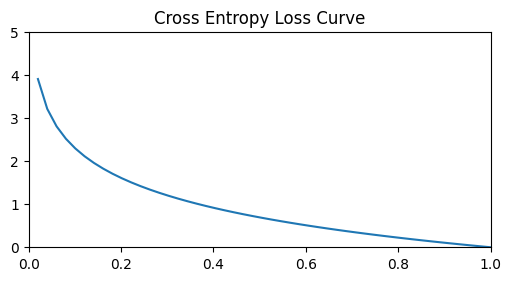

In [21]:
x = np.linspace(0, 2, 100) 
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(x, -np.log(x), label='Cross-Entropy function');
plt.xlim(0, 1)
plt.ylim(-0, 5) 
plt.title("Cross Entropy Loss Curve")

So through all this dumb math that makes no sense, what we are doing is this: 

<strong>For our model's predictions for the next word token, none of the probabilities predicted for any other tokens matter. Zero them out. For the probability predicted for the true next word, scale the loss such that smaller probabilities are punished exponentially harsher than larger, more confident probabilities. Use this calculated loss to recalibrate all gradients accordingly in order to minimize total loss.</strong>

# Noam Scheduler

In [22]:
class NoamScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(NoamScheduler, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return self.d_model**-0.5 * tf.minimum(step**-0.5, step * self.warmup_steps**-1.5)

The Noam Scheduler is actually a really cool function that helps us with defining the best learning rate values for our model. The <strong>Learning Rate</strong> of our model defines how big of a step we should take in our loss function towards a local minimum. This is the cornerstone conept of machine learing that all AI engineers already know but I enjoy talking about it so I will explain it myself. The reason why we can't just calculate where the derivative of the loss function is 0 and use that point is threefold:

Firstly, and most importantly, while neural network loss functions <strong>are differentiable</strong>, they are almost never solvable in closed form. Okay... what does that mean? It means we can't just write down a formula and solve it directly using calculus. The composition of multiple nonlinear functions (softmax, attention, ReLU, etc.) makes the overall function so complex that finding an analytical solution to minimize the loss is completely infeasible. You know you're in for a hell of a ride when calculus isn't well equipped enough to save you LOL. 

Secondly, the number of parameters in modern AI models is <em>massive</em>. Some transformers have hundreds of millions to billions of parameters. Attempting to solve a system of nonlinear equations with that many variables would be an astronomically high computational task. Even with powerful hardware, there's no realistic way to brute-force a solution.

Lastly, the <strong>Loss Landscape</strong> is the space defined by all possible values of the model's parameters and their corresponding loss values. This space is <em>freakishy complex</em> and understandably so. It's filled with saddle points, local minima, and plateaus that could register as a solution. Even if we somehow had an exact mathematical formula for the minimum, we’d still face the problem of discerning solutions from the best solution. 

So instead of "solving" the loss function equation outright for where the gradient is zero, we take steps towards minima using the learning rate. The learning rate can be uniform for all interations if we want it to be. It is not an uncommon thing for less complex functions where we are just using <strong> Stochastic Gradient Descent </strong>. But a problem occurs when we set our learning rate too large or too small. 

When our learning rate is too large, we take big steps toward the minimum but often overshoot it and oscillate back and forth around the solution unable to get any closer to the minimum. This often kills training very early on. For small learning rates, we can take those precise steps further and futher towards our minimum when we are close to it. However, the problem is the convergence to the minimum is very slow and there is a ton of wasted computation. Also, models with too small of a learning rate can overfit easily. So the Noam Scheduler seeks to resolve these issues. 


\begin{align*}
\text{Learning Rate} = d_{\text{model}}^{-0.5} \cdot \min\left(\text{step\_num}^{-0.5}, \, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5} \right)
\end{align*}

The Noam Scheduler seeks to rectify the issues with selecting a learning rate by dynamically altering the value with each training step. The algorithm is actually taking the minimum of two functions, one where we increase the value of our learning rate linearly and another where we decrease the learning rate by the inverse sqare root of our step number. So the function can be visualized like a wave. At the very start of training the AI, we have very small values that helps our model find its bearings, but the learning rate then increases rapidly toward a peak. The zenith is defined prior to training with the warm up parameter. When we reach the end of the warm up period, the learning rate begins to slowly decrease with each training step. The idea of this dynamic learning rate is that we can take large leaps after a model starts finding the right track. But as we start to converge on a local minimum, we decrease the learning rate with each step to keep from overshooting it. 

# Adam Optimizer

# Object Definitions

In [23]:
# Loss, optimizer, metrics
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

learning_rate = NoamScheduler(EMBEDDING_DIM, warmup_steps=4000)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

bumblebee = Transformer(num_layers=2, d_model=8, num_heads=2, d_ff=20, vocab_size=100, dropout_rate=0.1)

# Training Step Definition

In [24]:
@tf.function
def train_step(eng_tensor, fr_tensor):
    # tar_inp is decoder input (everything except last token)
    # tar_real is target output (everything except first token)
    decoder_input = fr_tensor[:, :-1]
    target = fr_tensor[:, 1:]

    encoder_input = EmbeddingAndPositionalEncoding(
        sequence_length=SEQ_LEN_MAX,
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        name="source_embedding",
    ) (eng_tensor)

    decoder_input = EmbeddingAndPositionalEncoding(
        sequence_length=SEQ_LEN_MAX,
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        name="target_embedding",
    ) (decoder_input)

    # Create masks
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(eng_tensor, target)

    with tf.GradientTape() as tape:
        predictions = bumblebee(
            encoder_input=encoder_input,
            decoder_input=decoder_input,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=look_ahead_mask,
            dec_padding_mask=dec_padding_mask
        )
        loss = loss_function(target, predictions)

    gradients = tape.gradient(loss, bumblebee.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bumblebee.trainable_variables))

    return loss

# Training Loop 

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    loss = train_step(eng_tensor, eng_tensor)
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy():.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'multi_head_attention_1' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'multi_head_attention_2' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not s

Epoch 1, Loss: 4.5861
Epoch 2, Loss: 4.5861
Epoch 3, Loss: 4.5860
Epoch 4, Loss: 4.5859
Epoch 5, Loss: 4.5857
Epoch 6, Loss: 4.5855
Epoch 7, Loss: 4.5851
Epoch 8, Loss: 4.5848
Epoch 9, Loss: 4.5843
Epoch 10, Loss: 4.5838
